<div style="text-align:center"> 
    <p style="font-size: 50px; margin-bottom: 0">Chemical Cartography</p>
    <p style="font-size: 20px; font-style: italic">ASTR 511 HW3 - Tom Wagg</p>
    <p>(glad we're continuing the theme of c alliteration in these titles haha)</p>
</div>

In [2]:
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord

import numpy as np

import pandas as pd
pd.options.display.max_columns = None

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use("dark_background")

from scipy.stats import norm
from scipy.optimize import curve_fit

%config InlineBackend.figure_format = "retina"

# Part 1

## 1.1: The Data

In [3]:
dat = Table.read('allStarLite-dr17-synspec_rev1.fits', format='fits', hdu=1)

In [4]:
f'In this dataset there {len(dat)} stars each with {len(dat.columns)} columns - some of which are themselves multidimensional!!'

'In this dataset there 733901 stars each with 191 columns - some of which are themselves multidimensional!!'

My approximate reaction to this:
![](danger.gif)

In [5]:
# drop the multidimensional columns, switch to Pandas because why not and drop the NaNs
names = [name for name in dat.colnames if len(dat[name].shape) <= 1]
df = dat[names].to_pandas()
df = df.dropna(subset=["ALPHA_M", "FE_H", "RA", "DEC", "GAIAEDR3_R_MED_GEO"])

## 1.2: Wallerstein-Tinsley Diagram

Here are some simple polygons for the discs, I just did these roughly by eye when looking at the plots.

In [6]:
low_alpha_path = mpl.path.Path(
    np.array([
        [-0.5, 0.15],
        [-0.6, 0.15],
        [-0.8, 0.1],
        [-0.7, 0.05],
        [-0.6, 0.03],
        [0, -0.07],
        [0.55, -0.07],
        [0.58, 0.05],
        [0.2, 0.05],
        [-0.5, 0.15]
    ])
)
high_alpha_path = mpl.path.Path(
    np.array([
        [0.4, 0.05],
        [0.2, 0.05],
        [-0.5, 0.15],
        [-1, 0.23],
        [-1.3, 0.28],
        [-1.3, 0.35],
        [0, 0.36],
        [0.4, 0.05]
    ])
)

low_alpha_mask = low_alpha_path.contains_points(np.stack((df['FE_H'], df['ALPHA_M'])).T)
high_alpha_mask = high_alpha_path.contains_points(np.stack((df['FE_H'], df['ALPHA_M'])).T)

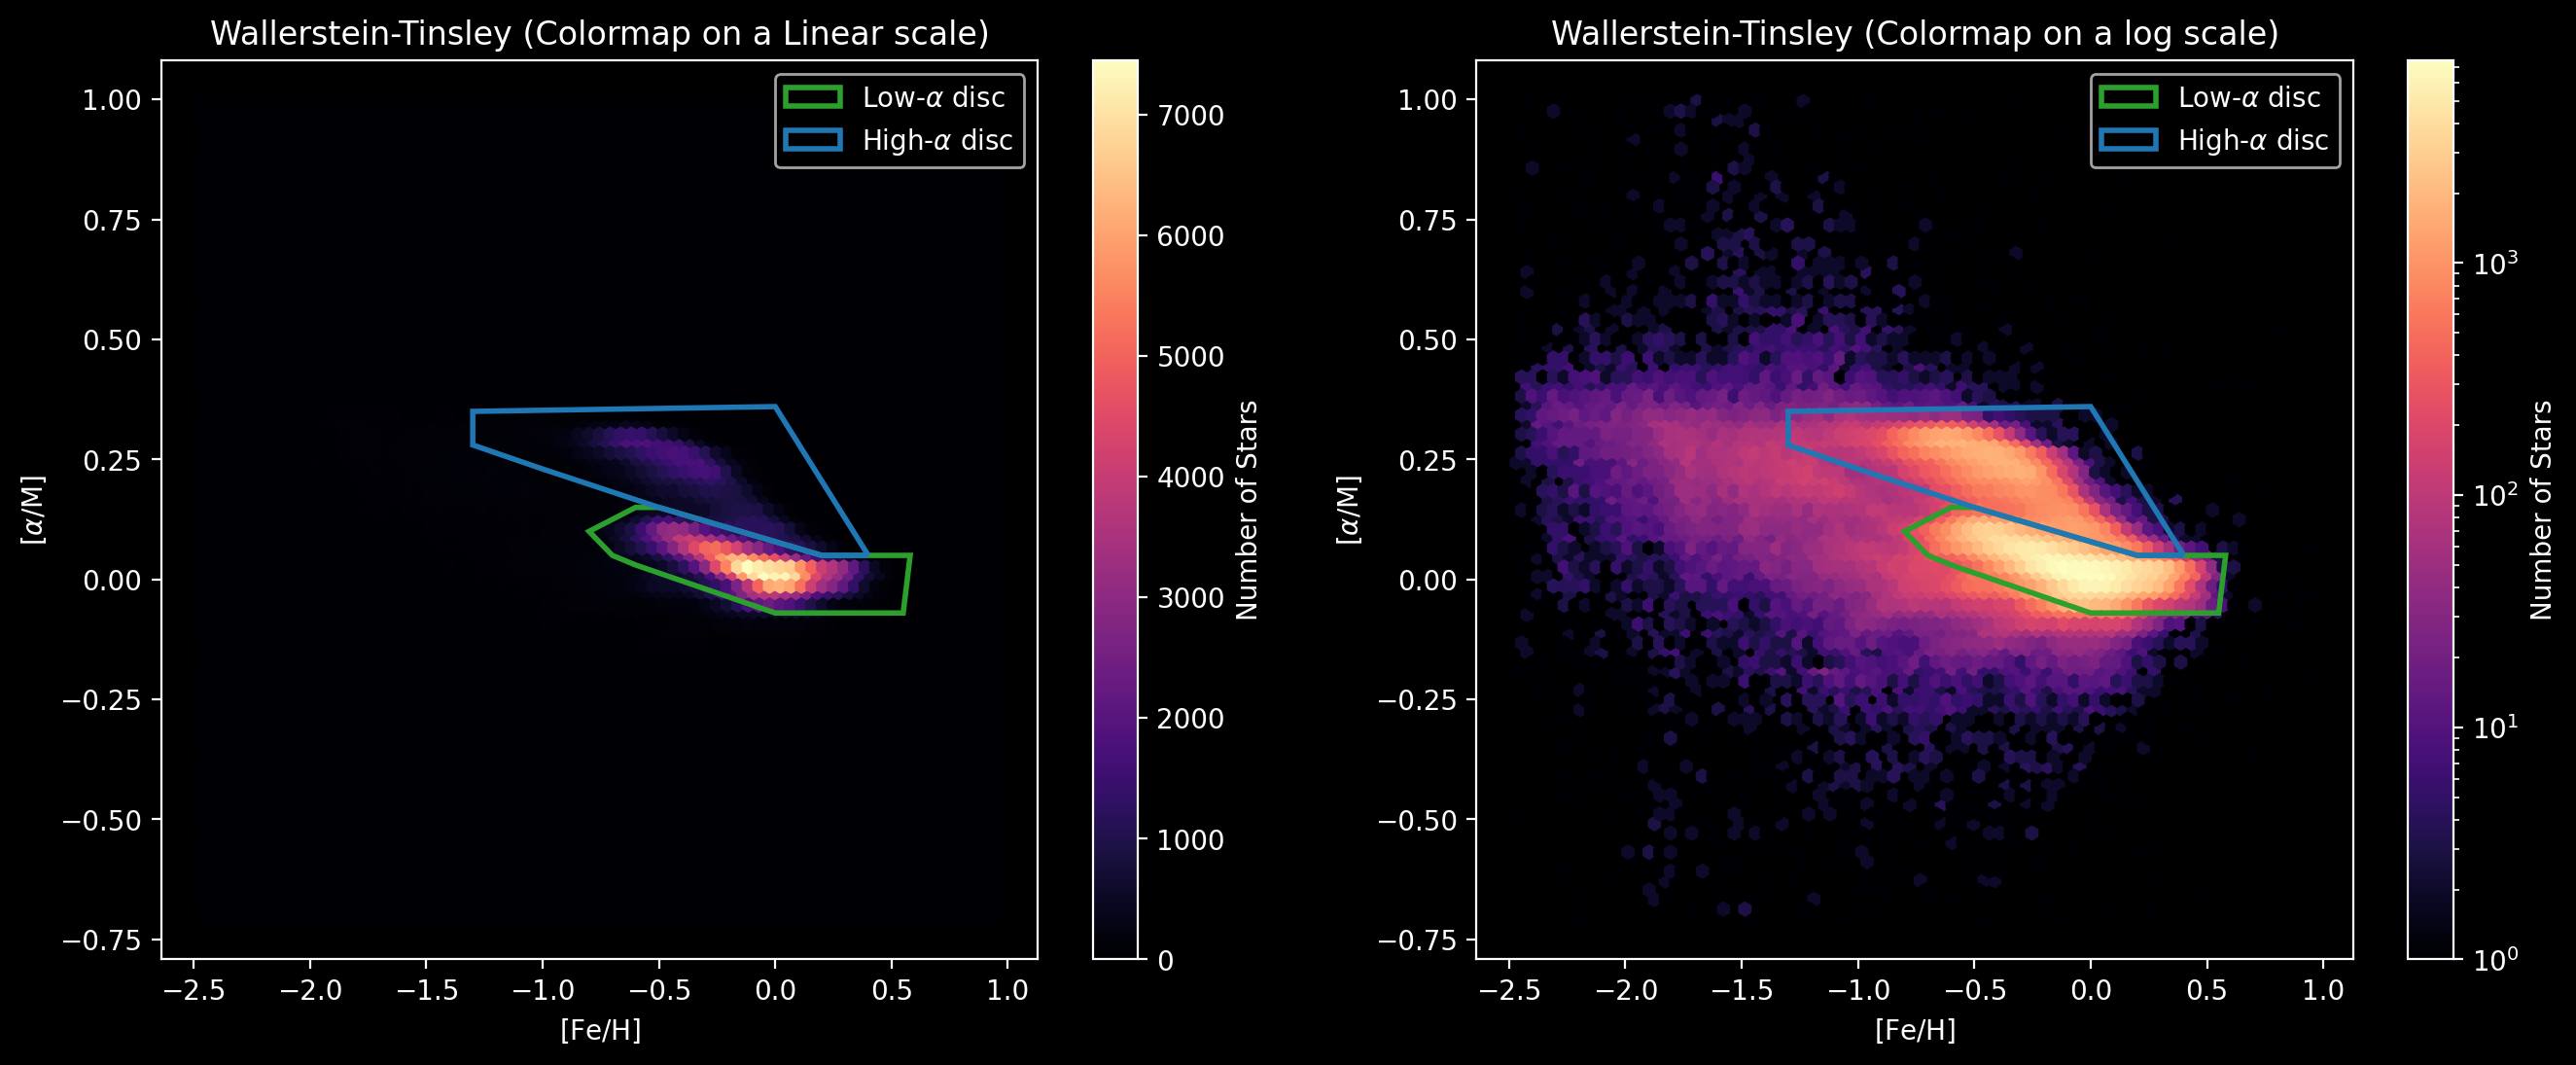

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, scale in zip(axes, [None, "log"]):
    hexbin = ax.hexbin(df["FE_H"], df["ALPHA_M"], cmap="magma", bins=scale, gridsize=75)

    for path, colour, label in zip([low_alpha_path, high_alpha_path],
                                   ["tab:green", "tab:blue"],
                                   [r"Low-$\alpha$ disc", r"High-$\alpha$ disc"]):
        patch = mpl.patches.PathPatch(path, fc='none', edgecolor=colour, lw=2, label=label)
        ax.add_artist(patch)

    fig.colorbar(hexbin, label="Number of Stars", ax=ax)

    if scale is None:
        scale = "Linear"
    ax.set_title(f"Wallerstein-Tinsley (Colormap on a {scale} scale)")

    ax.set_xlabel(r"$\rm [Fe / H]$")
    ax.set_ylabel(r"$[\alpha / {\rm M}]$")

    ax.legend()

plt.show()


## 1.3: Dwarfs vs. Giants 

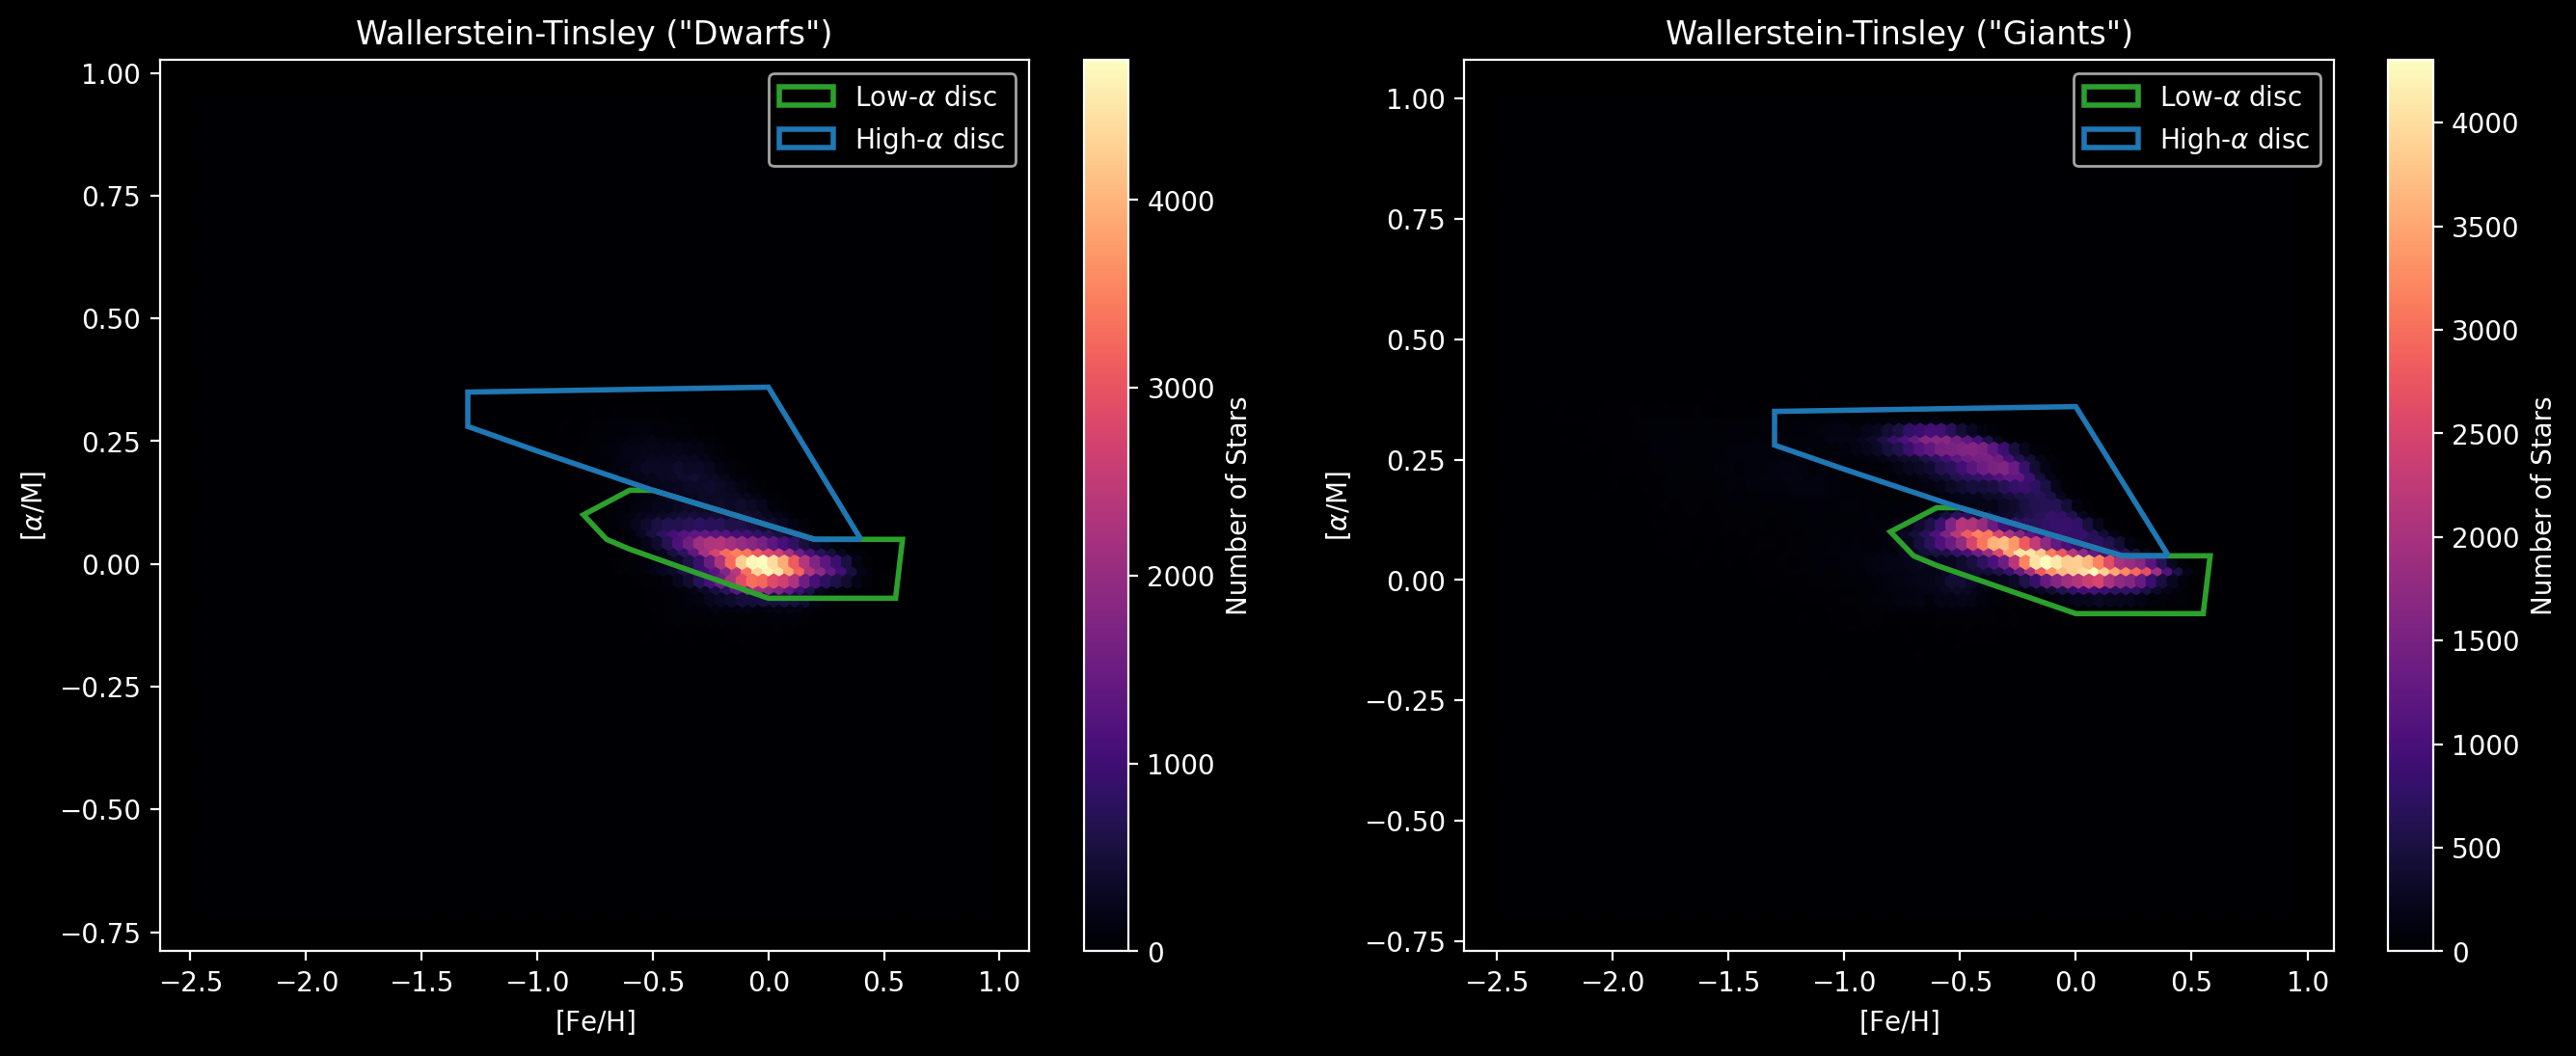

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

dwarfs, giants = (df["LOGG"] >= 3.5), (df["LOGG"] < 3.5)

for ax, mask, title in zip(axes, [dwarfs, giants], ["Dwarfs", "Giants"]):
    hexbin = ax.hexbin(df["FE_H"][mask], df["ALPHA_M"][mask], cmap="magma", bins=None, gridsize=75)

    for path, colour, label in zip([low_alpha_path, high_alpha_path],
                                   ["tab:green", "tab:blue"],
                                   [r"Low-$\alpha$ disc", r"High-$\alpha$ disc"]):
        patch = mpl.patches.PathPatch(path, fc='none', edgecolor=colour, lw=2, label=label)
        ax.add_artist(patch)

    fig.colorbar(hexbin, label="Number of Stars", ax=ax)

    if scale is None:
        scale = "Linear"
    ax.set_title(f'Wallerstein-Tinsley (\"{title}\")')

    ax.set_xlabel(r"$\rm [Fe / H]$")
    ax.set_ylabel(r"$[\alpha / {\rm M}]$")

    ax.legend()

plt.show()


So it looks to me like both discs are present for the Giants, but we can only see thin disc for the Dwarfs!

# Part Two

## 2.1: Scale height

In [9]:
coords = SkyCoord(ra=df["RA"].values * u.deg,
                  dec=df["DEC"].values * u.deg,
                  distance=df["GAIAEDR3_R_MED_GEO"].values * u.pc,
                  frame="icrs").transform_to("galactocentric")
reasonable_z = np.abs(coords.z.to(u.kpc).value) < 5

I find 202035 Dwarfs in the Low-$\alpha$ disc
I find 26347 Dwarfs in the High-$\alpha$ disc
I find 234174 Giants in the Low-$\alpha$ disc
I find 109054 Giants in the High-$\alpha$ disc


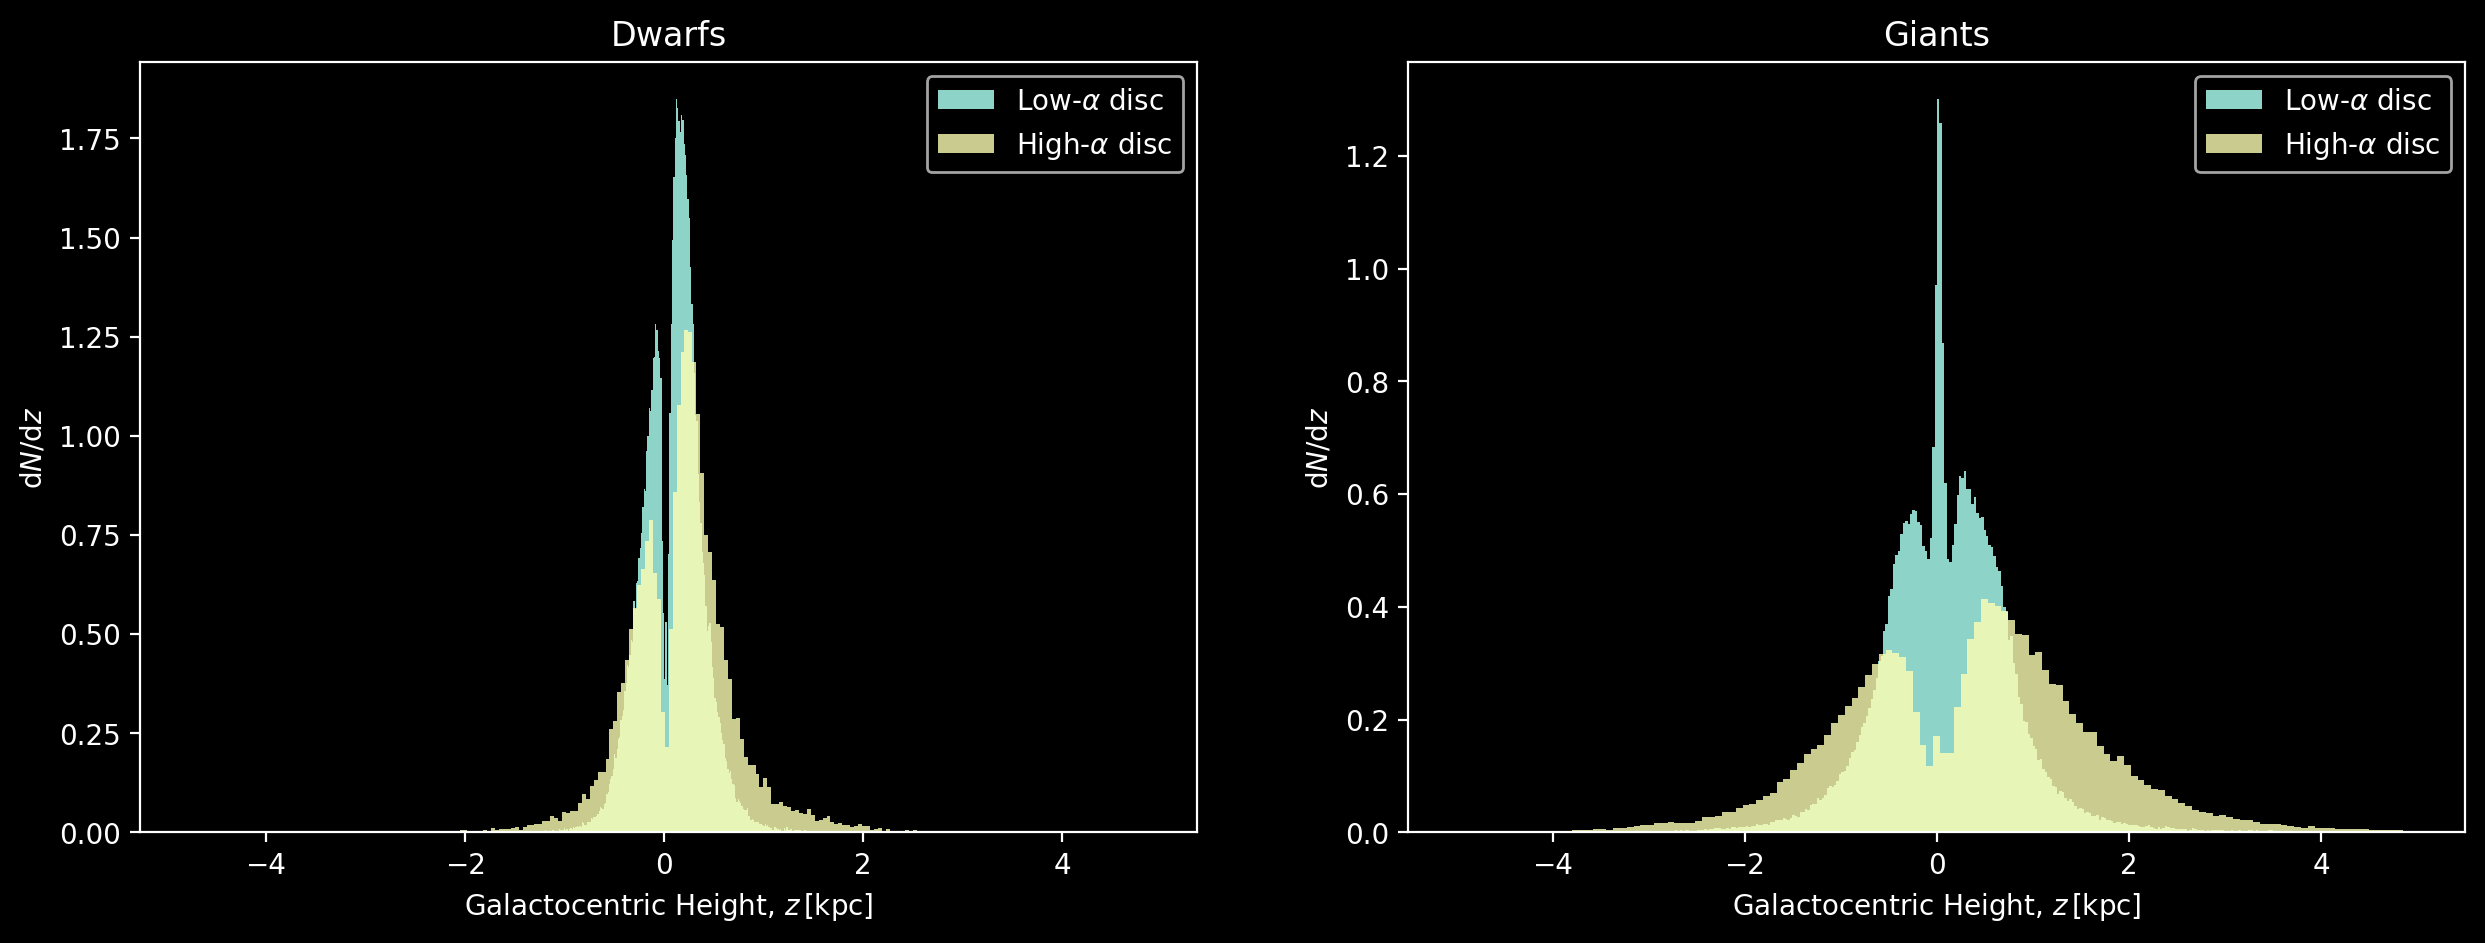

In [21]:
def gaussian(x, mu, sigma):
    return norm.pdf(x, loc=mu, scale=sigma)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for ax, dgmask, title in zip(axes, [dwarfs, giants], ["Dwarfs", "Giants"]):
    for mask, colour, label in zip([low_alpha_mask, high_alpha_mask], ["C0", "C1"], [r"Low-$\alpha$ disc", r"High-$\alpha$ disc"]):
        print(f'I find {(reasonable_z & mask & dgmask).sum()} {title} in the {label}')
        ax.hist(coords.z.to(u.kpc).value[reasonable_z & mask & dgmask], bins="fd", density=True, color=colour,
                alpha=0.8 if colour == "C1" else 1, zorder=-1, label=label);
    ax.set_title(title)

for ax in axes:
    ax.legend()
    ax.set_xlabel(r"Galactocentric Height, $z \, [\rm kpc]$")
    ax.set_ylabel(r"$\mathrm{d}N / \mathrm{d}z$")

plt.show()

It seems like the dwarfs trace the thin disc well whilst the giants trace the thick disc better.

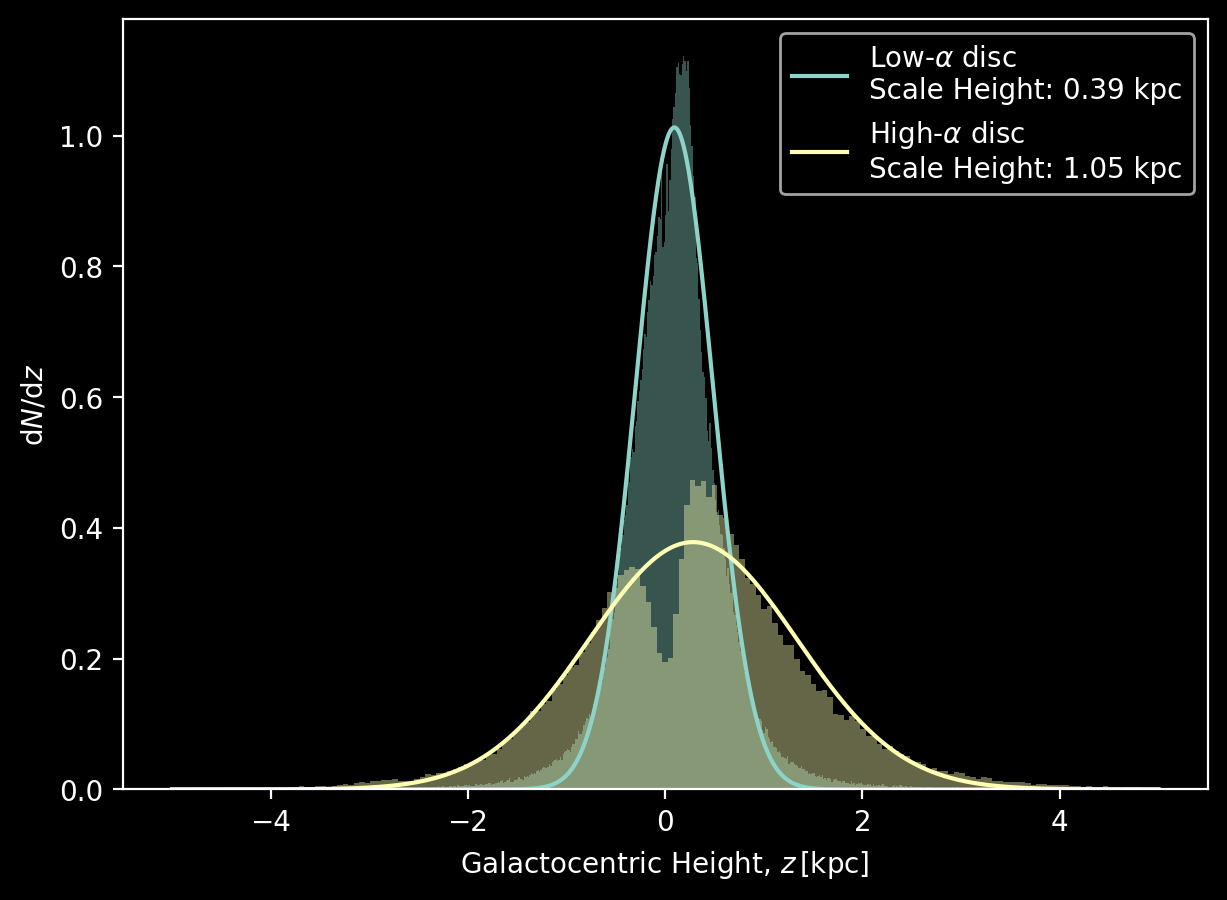

In [10]:
def gaussian(x, mu, sigma):
    return norm.pdf(x, loc=mu, scale=sigma)

fig, ax = plt.subplots(figsize=(7, 5))

for mask, colour, label in zip([low_alpha_mask, high_alpha_mask], ["C0", "C1"], [r"Low-$\alpha$ disc", r"High-$\alpha$ disc"]):
    h, bins = np.histogram(coords.z.to(u.kpc).value[reasonable_z & mask], bins="fd", density=True)
    bin_centres = (bins[1:] + bins[:-1]) / 2
    popt, pcov = curve_fit(gaussian, xdata=bin_centres, ydata=h)

    ax.hist(coords.z.to(u.kpc).value[reasonable_z & mask], bins="fd", density=True, color=colour, alpha=0.4, zorder=-1);

    mu, sigma = popt
    z_range = np.linspace(-5, 5, 10000)
    ax.plot(z_range, gaussian(z_range, mu, sigma), color=colour, label=label + f"\nScale Height: {sigma:1.2f} kpc")

ax.legend()
ax.set_xlabel(r"Galactocentric Height, $z \, [\rm kpc]$")
ax.set_ylabel(r"$\mathrm{d}N / \mathrm{d}z$")

plt.show()

## 2.2: Mean metallicity in plane

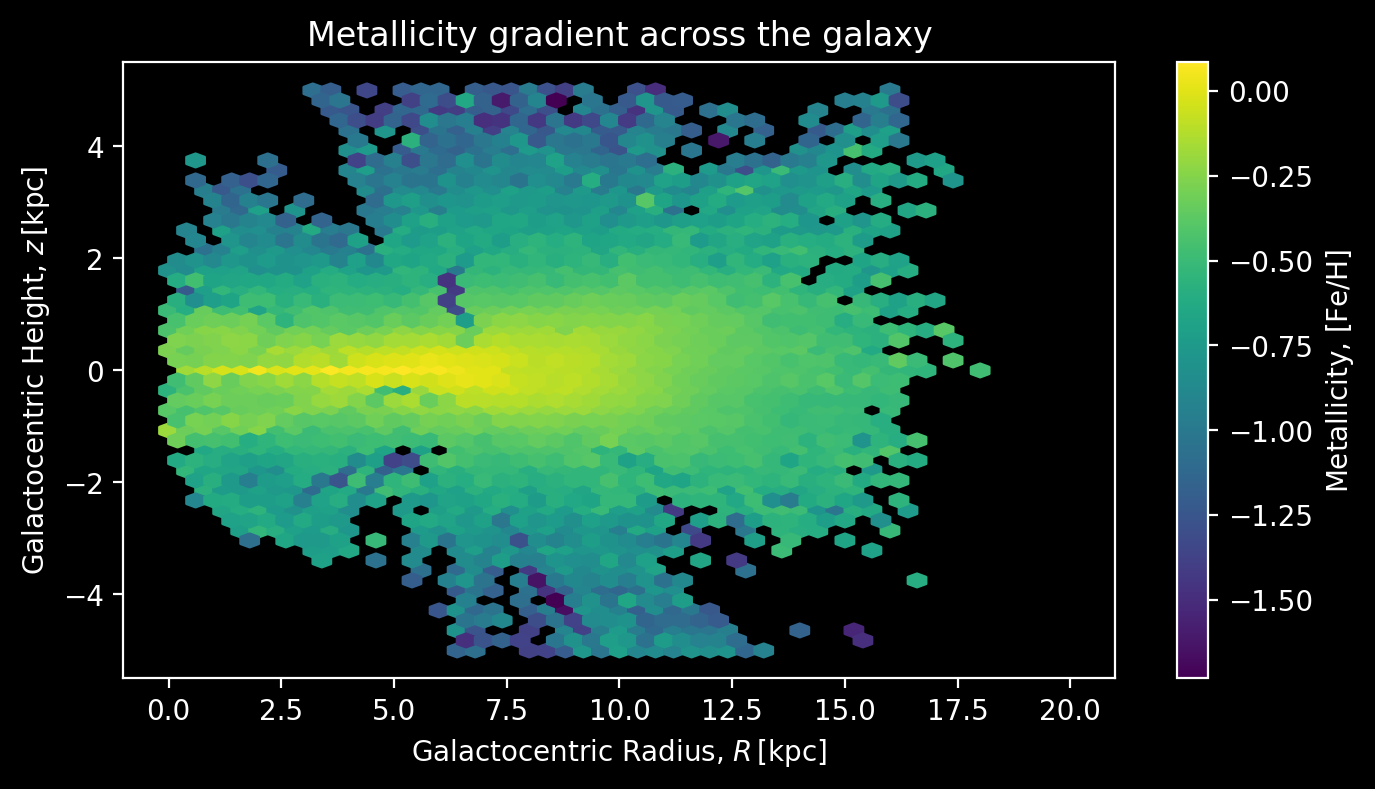

In [11]:
R = ((coords.x**2 + coords.y**2)**(0.5)).to(u.kpc).value

# get the mean as long as you've got some minimum number of stars
def reduce_func(x):
    if len(x) > 5:
        return np.mean(x)
    else:
        return np.nan

fig, ax = plt.subplots(figsize=(8, 4))

hexbin = ax.hexbin(R, coords.z.to(u.kpc).value,
                   C=df["FE_H"].values, reduce_C_function=reduce_func,
                   extent=(0, 20, -5, 5), cmap="viridis", gridsize=50)

fig.colorbar(hexbin, label=r"Metallicity, $\rm [Fe / H]$")

ax.set_xlabel(r"Galactocentric Radius, $R \, [\rm kpc]$")
ax.set_ylabel(r"Galactocentric Height, $z \, [\rm kpc]$")

ax.set_title("Metallicity gradient across the galaxy")

plt.show()

We can see that as you increase in radius and/or height the metallicity decreases, where the trend is much more abrupt in $z$ than in $R$.

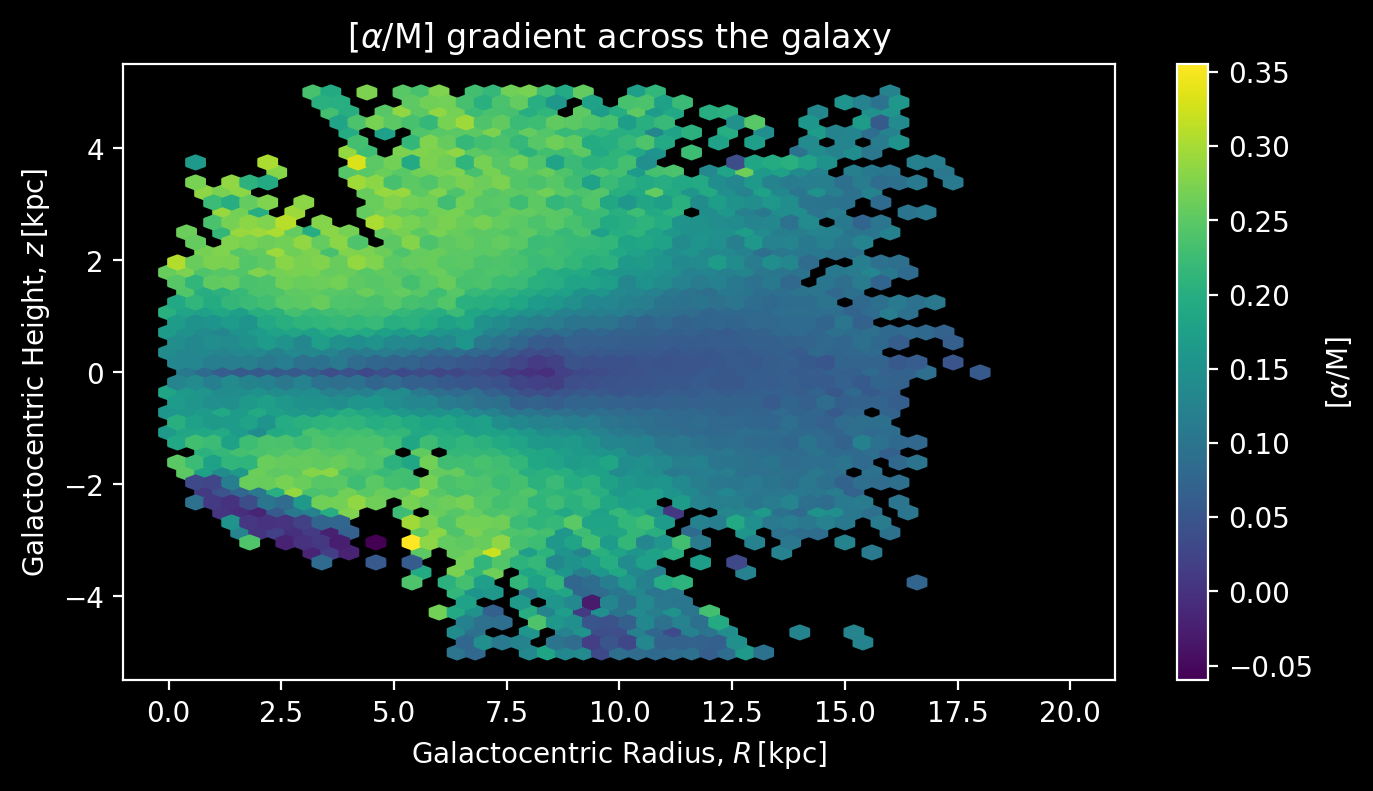

In [23]:
R = ((coords.x**2 + coords.y**2)**(0.5)).to(u.kpc).value

# get the mean as long as you've got some minimum number of stars
def reduce_func(x):
    if len(x) > 5:
        return np.mean(x)
    else:
        return np.nan

fig, ax = plt.subplots(figsize=(8, 4))

hexbin = ax.hexbin(R, coords.z.to(u.kpc).value,
                   C=df["ALPHA_M"].values, reduce_C_function=reduce_func,
                   extent=(0, 20, -5, 5), cmap="viridis", gridsize=50)

fig.colorbar(hexbin, label=r"$[\alpha / {\rm M}]$")

ax.set_xlabel(r"Galactocentric Radius, $R \, [\rm kpc]$")
ax.set_ylabel(r"Galactocentric Height, $z \, [\rm kpc]$")

ax.set_title(r"$[\alpha/{\rm M}]$ gradient across the galaxy")

plt.show()

Inversely, $[\alpha, {\rm M}]$, increases as you in height $z$, there doesn't seem to be much $R$ dependence. I am intrigued by the weird bit in the bottom left as well.